Note to Grader: Due to errors in loading gzip data, I have uncompressed csv before loading. If you are unable to regenerate results please contact me at keval.pipalia@mail.mcgill.ca, I manage dependency for each assignment using poetry so I can share the poetry.lock file for regeneration.

### Question 2 [6%] Bayesian fine-mapping
For a phenotype of interest, we have identified a GWAS locus based on N=498 individuals, which harbour 100 SNPs. As shown in Figure 1, because of the extensive LD, identifying the
1
 Figure 1: Manhattan plot for the GWAS locus to finemap. The causal SNPs are in fact coloured in red although in practice we will know which SNPs are causal.
causal SNPs based on the p-values of the z-scores alone is error prone. Because this is an as- signment, I have highlighted the causal SNPs namely rs10104559, rs1365732, rs12676370 but of course in real world applications, we will not know them.
Download the marginal z-score and LD matrix from here:
https://drive.google.com/drive/folders/1tr7BCceyIcKxiO_i6iCNjvk44HHpImgG?usp=sharing
Your task is to implement a simplified version of the FINEMAP algorithm discussed in Lecture 5. To make the task easier, you may assume there are maximum 3 causal SNPs in the locus. You can divide the tasks into four small tasks:

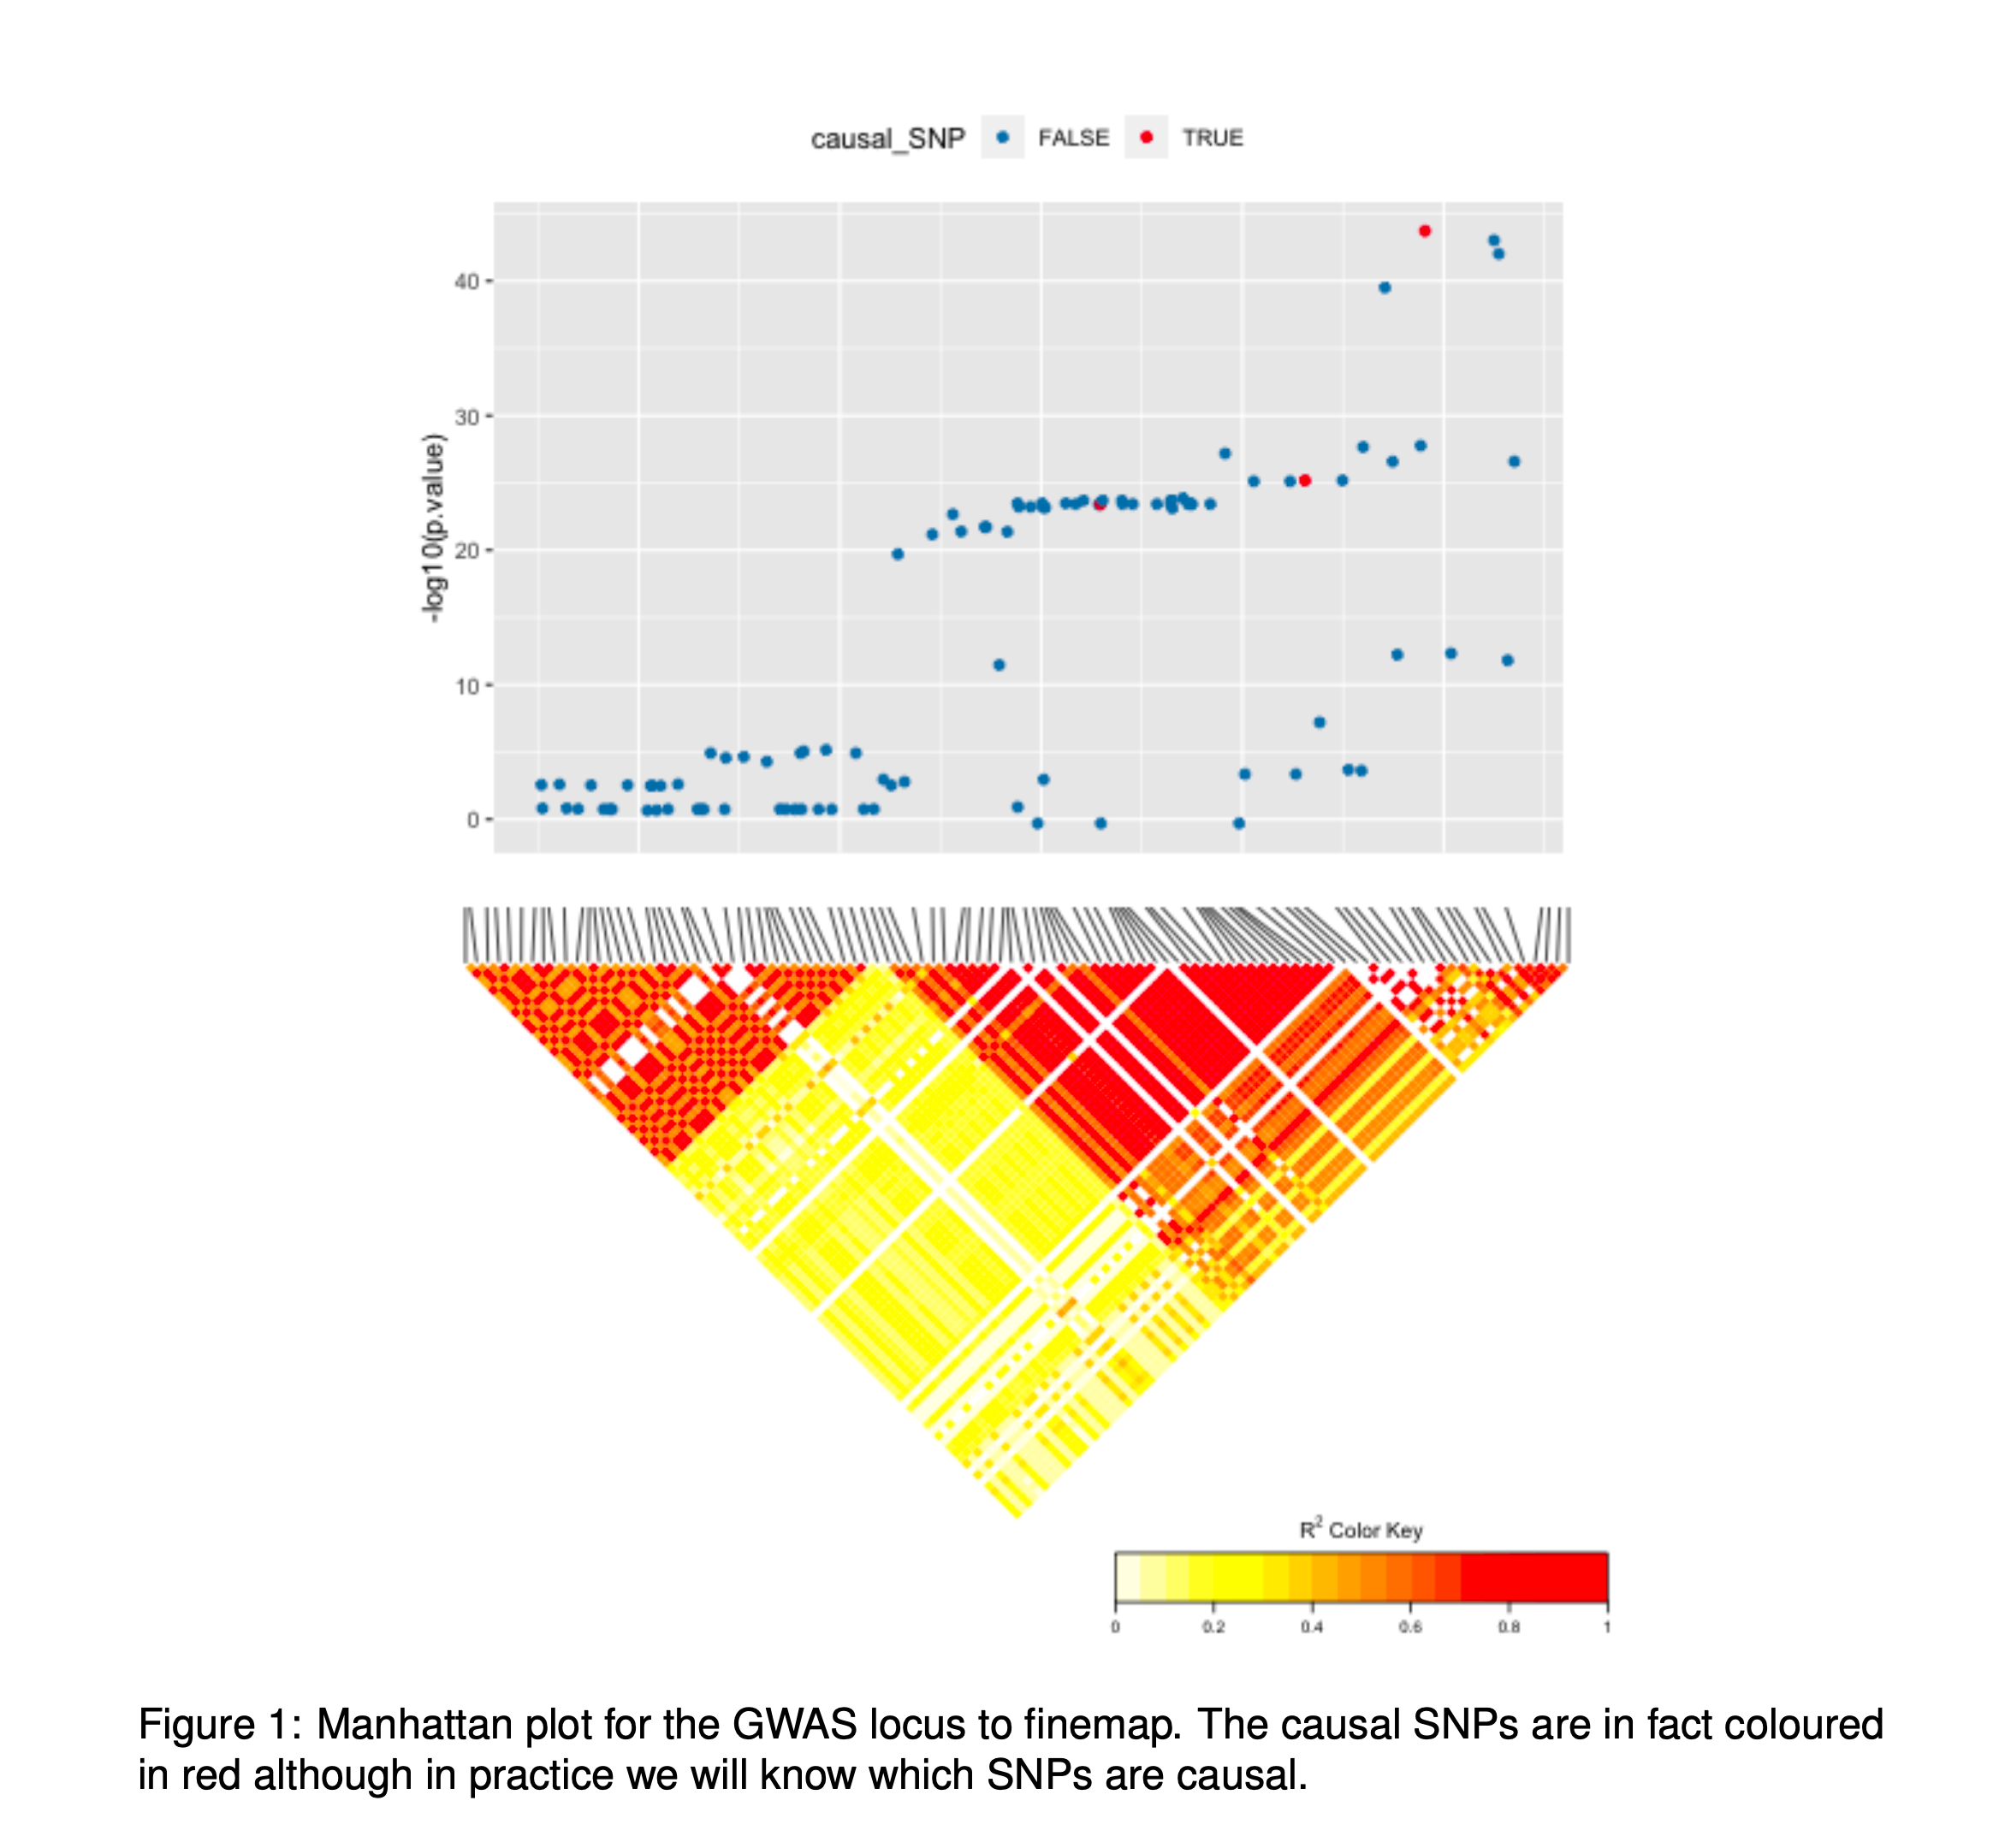

##### Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from scipy.stats import multivariate_normal
from itertools import combinations
import math
from scipy.stats import norm

In [2]:
seaborn.set_theme()

In [3]:
# Please notice the path difference, also I was getting some errors loading gzip directly so, I am using uncompressed versions of file.
# If you are using linux you can use `gzip -d filename` to uncompress files.
ld_matrix = pd.read_csv('data/Q2/LD.csv', index_col=0)
z_score = pd.read_csv('data/Q2/zscore.csv', index_col=0)
calculated_pip_score = pd.read_csv('data/Q2/SNP_pip.csv', index_col=0)

In [4]:
ld_matrix

,rs1387412,rs1489360,rs11774323,rs16881260,rs7009162,rs923433,rs1489361,rs6469328,rs16881313,rs2171707,...,rs13250058,rs9643057,rs4504665,rs12675941,rs10104559,rs4588886,rs10102107,rs10110311,rs4288405,rs4876333
rs1387412,0.997955,0.498150,0.916987,0.498150,0.482252,0.992618,0.496437,0.496437,0.496437,0.992618,...,0.312689,-0.052892,0.312151,-0.056787,0.244695,0.310131,0.231148,0.228360,0.297082,0.252882
rs1489360,0.498150,0.997955,0.529958,0.997955,0.968111,0.491712,0.990526,0.990526,0.990526,0.491712,...,0.074650,0.013158,0.077670,0.014984,0.086419,0.067394,0.074562,0.060657,0.066392,0.065816
rs11774323,0.916987,0.529958,0.997955,0.529958,0.511339,0.910765,0.527670,0.527670,0.527670,0.910765,...,0.317321,-0.052925,0.313200,-0.049517,0.251279,0.305044,0.230306,0.226434,0.291687,0.213760
rs16881260,0.498150,0.997955,0.529958,0.997955,0.968111,0.491712,0.990526,0.990526,0.990526,0.491712,...,0.074650,0.013158,0.077670,0.014984,0.086419,0.067394,0.074562,0.060657,0.066392,0.065816
rs7009162,0.482252,0.968111,0.511339,0.968111,0.997955,0.484638,0.975360,0.975360,0.975360,0.484638,...,0.053662,0.024635,0.064452,0.026430,0.065061,0.054043,0.061413,0.046998,0.053017,0.045543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rs4588886,0.310131,0.067394,0.305044,0.067394,0.054043,0.308677,0.061649,0.061649,0.061649,0.308677,...,0.712841,-0.216928,0.991496,-0.214440,0.732640,0.997955,0.730251,0.735846,0.981791,0.557795
rs10102107,0.231148,0.074562,0.230306,0.074562,0.061413,0.232046,0.071322,0.071322,0.071322,0.232046,...,0.890797,0.475634,0.723380,0.488963,0.982657,0.730251,0.997955,0.990240,0.736829,0.765534
rs10110311,0.228360,0.060657,0.226434,0.060657,0.046998,0.229193,0.057293,0.057293,0.057293,0.229193,...,0.898608,0.457516,0.729027,0.470728,0.975141,0.735846,0.990240,0.997955,0.742489,0.752814
rs4288405,0.297082,0.066392,0.291687,0.066392,0.053017,0.295646,0.060627,0.060627,0.060627,0.295646,...,0.707941,-0.203264,0.975152,-0.200699,0.727643,0.981791,0.736829,0.742489,0.997955,0.567099


In [5]:
z_score

,V1
rs1387412,2.993607
rs1489360,1.429609
rs11774323,3.016356
rs16881260,1.429609
rs7009162,1.370687
...,...
rs4588886,7.232882
rs10102107,13.870984
rs10110311,13.704032
rs4288405,7.071519


In [6]:
calculated_pip_score

,x
rs1387412,0.000103
rs1489360,0.000086
rs11774323,0.000102
rs16881260,0.000086
rs7009162,0.000089
...,...
rs4588886,0.001302
rs10102107,0.569810
rs10110311,0.330284
rs4288405,0.000734


In [7]:
snp_list = list(z_score.index)
snp_list

['rs1387412',
 'rs1489360',
 'rs11774323',
 'rs16881260',
 'rs7009162',
 'rs923433',
 'rs1489361',
 'rs6469328',
 'rs16881313',
 'rs2171707',
 'rs6996166',
 'rs10088693',
 'rs931410',
 'rs6469329',
 'rs6469330',
 'rs11991405',
 'rs11785408',
 'rs1546013',
 'rs4448249',
 'rs1489354',
 'rs10113434',
 'rs7388152',
 'rs10955548',
 'rs4289849',
 'rs12546759',
 'rs7463960',
 'rs10955554',
 'rs7388644',
 'rs13269197',
 'rs6469334',
 'rs7819770',
 'rs6469336',
 'rs4876347',
 'rs9649932',
 'rs10095358',
 'rs6469337',
 'rs11779737',
 'rs4493937',
 'rs10106643',
 'rs12681879',
 'rs1427188',
 'rs2114555',
 'rs2052801',
 'rs13278392',
 'rs4876280',
 'rs10104030',
 'rs1896238',
 'rs13264102',
 'rs4352877',
 'rs12543233',
 'rs1365727',
 'rs10091361',
 'rs11781492',
 'rs1427169',
 'rs16881541',
 'rs9693916',
 'rs10111397',
 'rs10102552',
 'rs1549550',
 'rs1427171',
 'rs3906482',
 'rs4515575',
 'rs1365732',
 'rs17586873',
 'rs7017740',
 'rs2351551',
 'rs2217144',
 'rs1593667',
 'rs3021375',
 'rs890564'

In [8]:
# get all combination of SNPs
config_1_snp = list(combinations(snp_list, 1))
config_2_snp = list(combinations(snp_list, 2))
config_3_snp = list(combinations(snp_list, 3))

#### Q1.1 (1%) Implement the efficient Bayes factor for each causal configurations:
y=Xλ+ε, ε∼N(0,σ2In), λ∼N(0,s2λσ2∆γ)
where s2λ is user-defined prior variance in the unit of σ2, ∆γ is the diagonal matrix with di- agonal equal to γ (causal configuration). You may assume that s2λ = 0.005. Therefore, assuming there are k causal SNPs, then ΣCC = Ns2Ik = 2.49Ik
For the multivariate Gaussian density function, we may find many existing libraries. In R, mvtnorm. In Python, it can be found in scipy https://docs.scipy.org/doc/scipy-0.14. 0/reference/generated/scipy.stats.multivariate_normal.html

In [9]:
# Calculate Bayes Factor for given configuration
def calculate_bf(snp):
    # Get z scores for given config
    z_cap = list(z_score.loc[snp]['V1'].values)

    # Calculate RCC + RCC * SUM_CC * RCC
    r_cc = ld_matrix.loc[snp][snp].values

    # To tackle positive definite error, workaround to making roundoff correlation to self snp =1
    for i in range(len(snp)):
        r_cc[i][i] = 1
    sum_cc = 2.49 * np.identity(len(snp))
    r_star = r_cc + np.matmul(r_cc, np.matmul(sum_cc, r_cc))
    
    x_mean = np.zeros(len(snp))

    numerator = multivariate_normal(x_mean, r_star).pdf(z_cap)
    denominator = multivariate_normal(x_mean, r_cc).pdf(z_cap)
    result = numerator / denominator
    return result
        

In [10]:
# Calculate BF for all possible configs with maximum 3 SNPs. Saving calculated bayes factors in a hashmap for easier access.
dict_BF = {}

configurations = [config_1_snp, config_2_snp, config_3_snp]

for i, config in enumerate(configurations, start=1):
    for snps in config:
        dict_BF[snps] = calculate_bf(list(snps))
    print(f"Completed for config_{i}")

Completed for config_1
Completed for config_2
Completed for config_3


#### Q1.2 (1%) Implement the prior calculation for each configurations

In [11]:
# Calculating Prior
def calculate_prior(k, m):
    p_snp_causal = 1 / m
    p_snp_not_causal = (m - 1) / m
    return pow(p_snp_causal, k) * pow(p_snp_not_causal, (m - k))

In [12]:
# Calculate Prior for all possible configs with maximum 3 SNPs.
prior_1 = calculate_prior(1, 100)
prior_2 = calculate_prior(2, 100)
prior_3 = calculate_prior(3, 100)

#### Q1.3 (2%) Implement posterior inference over all possible configurations

Implement posterior inference over all possible configurations assuming at maximum 3 causal SNPs (i.e.,  100C1 +  100C2 +  100C3 = 100 + 4950 + 161700 = 166, 750 possible configurations). Therefore, no stochastic sampling is required here (as opposed to the original FINEMAP).

To obtain all possible configurations, we may also use existing libraries. In R, this is done by gtools:combinations. In Python, check out itertools.combinations https://docs.python.org/2/library/itertools.html

Some configurations may result in non-finite multivariate Gaussian density. Discard those configurations.

Visualize the configuration posteriors by ranking them in increasing order as shown in Figure 2. As we can see, the vast majority of the configurations have very small posterior probabilities.



In [13]:
def calculate_posterior_sum(configs, prior):
    posterior_sum = 0
    for config in configs:
        bayesian_factor = dict_BF[config]
        posterior_sum += (bayesian_factor * prior)
    return posterior_sum

In [14]:
# Calculate Posterior for all possible configs with maximum 3 SNPs.
posterior_sum_1 = calculate_posterior_sum(config_1_snp, prior_1)
posterior_sum_2 = calculate_posterior_sum(config_2_snp, prior_2)
posterior_sum_3 = calculate_posterior_sum(config_3_snp, prior_3)

total_posterior_denominator = posterior_sum_1 + posterior_sum_2 + posterior_sum_3

In [15]:
# Function to calculate the posterior for a given configuration
def calculate_posterior(snp, prior):
    bayes_factor = dict_BF[snp]
    denominator = total_posterior_denominator - (bayes_factor * prior)
    return (bayes_factor * prior) / denominator

In [16]:
# Initialize dictionaries and lists
dict_posterior = {}
all_posterior = []

# Loop through configurations and priors
configurations = [config_1_snp, config_2_snp, config_3_snp]
priors = [prior_1, prior_2, prior_3]

for config, prior in zip(configurations, priors):
    for snps in config:
        a_posterior = calculate_posterior(snps, prior)
        dict_posterior[snps] = a_posterior
        all_posterior.append(a_posterior)

# Calculate the sum of all posteriors
sum_posterior = np.sum(all_posterior)

# Sort the list of all posteriors
sort_all_post = sorted(all_posterior)

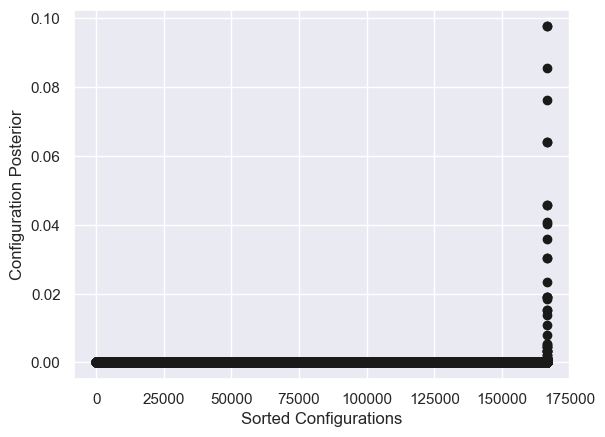

In [17]:
plt.figure()
plt.plot(sort_all_post, 'ko')
plt.xlabel("Sorted Configurations")
plt.ylabel("Configuration Posterior")
plt.show()

#### Q1.4 (2%) Implement posterior inclusion probabilities (PIP) 
Implement posterior inclusion probabilities (PIP) to calculate SNP-level posterior probabilities.
Visualize the normalized inferred PIP aligned with GWAS marginal -log10 p-values in Fig- ure 3. It looks like we missed one of the 3 causal SNPs due to its nearly perfect LD with the other causal SNPs. But in general, we are able to pull down quite a few non-causal ones. That is, if we were going to experimentally validate the top SNPs, 2 out of 6 top SNPs based on PIP are true causal ones, whereas we would have got a lot more false positives if we were to follow the -log10 P-values instead.


In [18]:
def calculate_pip(snp):
    score_numerator = 0
    
    for config in [config_1_snp, config_2_snp, config_3_snp]:
        for conf in config:
            if snp in conf:
                score_numerator += dict_posterior[conf]
    
    return score_numerator / sum_posterior

In [19]:
all_snps_pip = [calculate_pip(snp) for snp in snp_list]

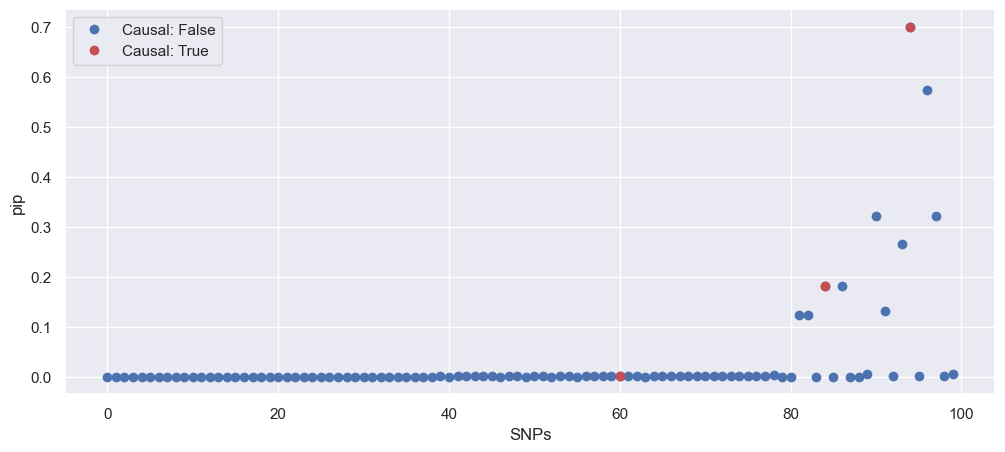

In [20]:
plt.figure(figsize=(12,5))

plt.plot(all_snps_pip, 'bo', label='Causal: False')
indices_to_mark = [all_snps_pip.index(calculate_pip('rs10104559')), all_snps_pip.index(calculate_pip('rs1365732')), all_snps_pip.index(calculate_pip('rs12676370'))]

plt.plot(indices_to_mark, [all_snps_pip[index] for index in indices_to_mark], 'ro', label='Causal: True')

plt.xlabel("SNPs")
plt.ylabel("pip")
plt.legend()
plt.show()

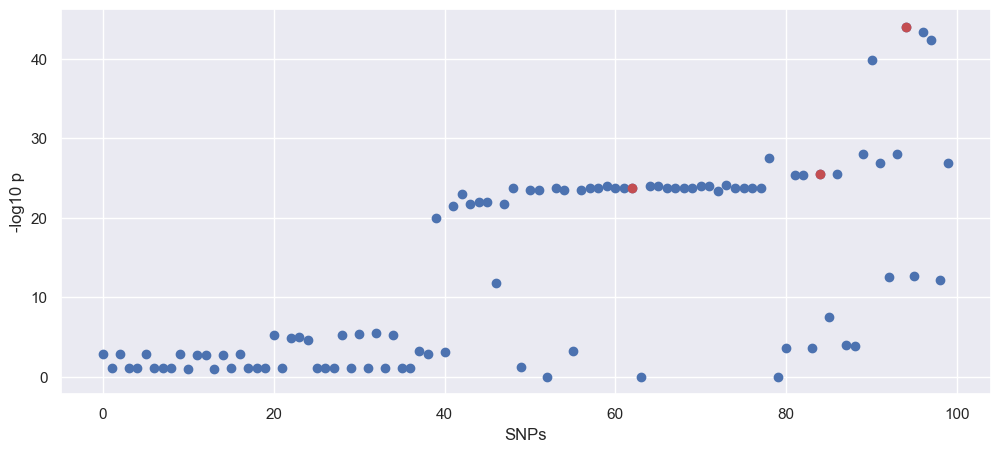

In [21]:
# Calculating - log 10 p 
def calculate_log_values(z_score_values):
    log_values = []
    for a_pip_s in z_score_values:
        val = norm.sf(a_pip_s)
        x = -math.log10(val)
        log_values.append(x)
    return log_values

z_score_list = z_score["V1"]
log_values = calculate_log_values(z_score_list)

indices_to_mark = ['rs10104559', 'rs1365732', 'rs12676370']
z_scores_mark = z_score.loc[indices_to_mark]['V1'].values
log_values_mark = calculate_log_values(z_scores_mark)

plt.figure(figsize=(12, 5))
plt.plot(log_values, 'bo')
for item in indices_to_mark:
    index = z_score.index.get_loc(item)
    plt.plot(index, log_values[index], 'ro')
plt.xlabel("SNPs")
plt.ylabel("-log10 p")
plt.show()

As it can be seen there are very few False Positive SNPs detected with PIP as compared to -log10 P-values.